## Movie Recommendation with RL
Pre-processed movie and rating data from [MovieLens Dataset](https://www.kaggle.com/datasets/grouplens/movielens-20m-dataset)

- No. of Movies : 185
- No. of Train Users : 1000
- No. of Test Users : 50

***Import dependencies, policy and custom classes***

In [2]:
import pandas as pd
import matplotlib.pyplot as plt

from setup import Recommender                   # Custom class for setting up the environment
from agent import CustomActorCriticPolicy       # Custom policy class
from env import make_recommender_env            # Custom environment class
from stable_baselines3 import PPO               # PPO algorithm from stable baselines

from inference import recommend_movies          # Function to recommend movies
from evaluate import evaluate_model             # Function to evaluate the model on 50 known users

import warnings
warnings.filterwarnings("ignore")

pd.set_option('display.max_colwidth', None)

***Create a Recommender object with all sequences, movie maps and user maps***

In [3]:
movie_features_path = './data/features/movie_features.csv'
rating_features_path = './data/features/ratings_features.csv'

rec = Recommender(movie_features_path, rating_features_path)        # Initialize the recommender object

***Load the Env and train the agent for 10 epochs***

In [4]:
print("State Seq Length: ", len(rec.state_sequences))            # Number of users in the environment

steps=0
for uid, seq in rec.state_sequences.items():
    steps += len(seq)

print("Total Steps: ", steps)                                    # Total number of steps in the environment 

State Seq Length:  1000
Total Steps:  4083


In [ ]:
env = make_recommender_env(1, rec)                                  # Create the environment
model = PPO(CustomActorCriticPolicy, env, verbose=1, n_steps=30)    # Initialize the model
model.learn(total_timesteps=steps*10)                               # Train the model for 10 epochs

Using cpu device
----------------------------
| time/              |     |
|    fps             | 111 |
|    iterations      | 1   |
|    time_elapsed    | 0   |
|    total_timesteps | 30  |
----------------------------
---------------------------------------
| time/                   |           |
|    fps                  | 39        |
|    iterations           | 2         |
|    time_elapsed         | 1         |
|    total_timesteps      | 60        |
| train/                  |           |
|    approx_kl            | 166.70149 |
|    clip_fraction        | 1         |
|    clip_range           | 0.2       |
|    entropy_loss         | -263      |
|    explained_variance   | -0.00298  |
|    learning_rate        | 0.0003    |
|    loss                 | 289       |
|    n_updates            | 10        |
|    policy_gradient_loss | 0.342     |
|    std                  | 1         |
|    value_loss           | 630       |
---------------------------------------
--------------------

***Save the trained PPO object/ Load the saved PPO object***

In [ ]:
# model.save('./saved/ppo_recommender_10e')                 # Save the model

In [5]:
model = PPO.load('./saved/ppo_recommender_10e')             # Load the model

***Visualize Reward Distribution***

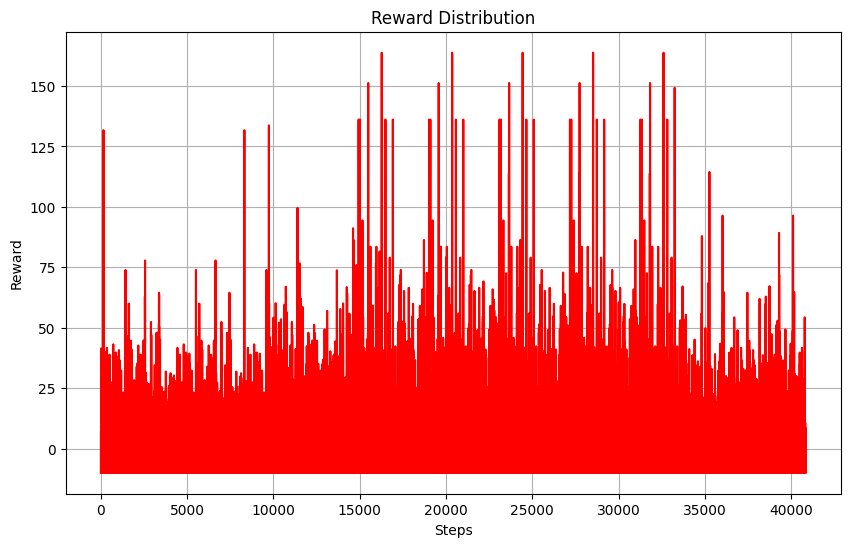

In [5]:
df = pd.read_csv('./data/log/rewards_log.csv')
df = df[(df['0'] >= -30) & (df['0'] <= 180)]

plt.figure(figsize=(10, 6))
plt.plot(df['Unnamed: 0'], df['0'], color='red')
plt.title('Reward Distribution')
plt.xlabel('Steps')
plt.ylabel('Reward')
plt.grid(True)
plt.show()                                                # Plot the reward distribution

***Recommend 5 movies to any user based on previously watched list***

In [6]:
user_id = 8             # Known User
user_watched_movies = [9, 52, 48, 7, 18, 16, 23, 36, 1, 53, 10, 43, 28, 40, 4, 64, 66, 70, 67, 41, 58]
user_watched_ratings = [3., 4., 4., 4., 4., 5., 5., 4., 4., 3., 4., 3., 3., 2., 3., 4., 4., 3., 2., 3., 4.]

recommended_movies = recommend_movies(model, user_id, user_watched_movies, user_watched_ratings, rec)           # Recommend movies to the user
print(recommended_movies)

[1858 1834  152 1928 3871]


In [7]:
user_id = 1500          # Unknown User
user_watched_movies = [101, 94, 55, 31, 66, 103, 30, 63, 184, 116]
user_watched_ratings = [4., 3., 4., 3., 5., 4., 2., 4., 3., 5.]

recommended_movies = recommend_movies(model, user_id, user_watched_movies, user_watched_ratings, rec)           # Recommend movies to the user
print(recommended_movies)

[  229  1689 53453  1620  1690]


***Compare the Recommended movies with Watched movies on random sample of 10 Unknown Users (Out of training data)***

In [ ]:
# pd.set_option('display.max_colwidth', None)

In [ ]:
from evaluate import test_recommender                           # Function to test the recommender on 10 unknown users
from evaluate import view_all_movies_from_test                  # Function to print all movies recommended in test_df

test_df = test_recommender(model, rec)                                        # Get watchlist of 10 random Unknown users
test_df[['userIndex','watchedMoviesId','watchedMoviesRating','recMovies']]

,userIndex,watchedMoviesId,watchedMoviesRating,recMovies
0,1479,"[2716, 2997, 1580, 10, 1240, 541, 253, 1136, 4011, 434]","[4.0, 3.0, 3.5, 4.0, 4.0, 4.5, 4.0, 4.5, 4.5, 3.5]","[230, 1762, 3830, 1690, 1805]"
1,1035,"[2384, 733, 1580, 434, 1240, 21, 95, 1136, 541, 2716]","[2.0, 3.0, 3.5, 2.0, 3.5, 3.5, 2.0, 4.0, 5.0, 3.5]","[241, 1805, 172, 1834, 1762]"
2,1373,"[1500, 1240, 628, 317, 3052, 1012, 455, 2461, 2321, 1391]","[1.5, 3.0, 3.0, 0.5, 2.0, 1.5, 2.0, 0.5, 2.0, 0.5]","[229, 1762, 152, 1690, 71821]"
3,1404,"[1240, 2867, 1965, 2407, 2467, 2408, 1580, 733, 21, 2170]","[5.0, 2.0, 2.0, 3.0, 2.0, 2.0, 3.0, 5.0, 2.0, 1.0]","[230, 1620, 169, 1604, 71821]"
4,1028,"[541, 917, 1240, 1580, 1391, 748, 920, 1183, 2067, 34]","[5.0, 3.0, 4.0, 4.0, 3.0, 4.0, 3.0, 5.0, 3.0, 4.0]","[230, 1805, 1834, 169, 3871]"
5,1436,"[434, 253, 10, 34, 21, 225, 230, 280, 733, 229]","[4.0, 4.0, 3.0, 4.0, 5.0, 4.0, 4.0, 4.0, 4.0, 5.0]","[291, 1858, 1834, 183, 1928]"
6,1347,"[1136, 2716, 1580, 34, 253, 2407, 1391, 1321, 1266, 256]","[5.0, 4.0, 4.5, 3.5, 4.0, 4.0, 3.5, 4.0, 5.0, 3.5]","[230, 1762, 1805, 169, 71821]"
7,1023,"[3052, 920, 34, 1136, 2997, 2716, 1500, 2321, 4128, 1580]","[3.0, 5.0, 4.0, 5.0, 4.0, 5.0, 4.0, 4.0, 4.0, 4.0]","[1689, 230, 2919, 169, 3830]"
8,1156,"[3052, 531, 262, 6502, 2997, 4011, 1500, 541, 2321, 1499]","[5.0, 4.0, 3.5, 4.0, 4.0, 3.0, 4.0, 3.5, 3.0, 0.5]","[229, 71821, 32735, 1620, 1689]"
9,1194,"[1580, 748, 379, 1391, 338, 172, 34, 1834, 541, 10]","[5.0, 2.0, 2.0, 1.0, 4.0, 3.0, 4.0, 3.0, 4.0, 2.0]","[1858, 253, 1805, 3871, 1928]"


In [ ]:
view_df = test_df[['userIndex', 'watchedMoviesDesc', 'recMoviesDesc']]
view_df['watchedMoviesList'] = view_df['watchedMoviesDesc'].apply(lambda x: [x[i]['desc'] for i in range(len(x))])
view_df['recMoviesList'] = view_df['recMoviesDesc'].apply(lambda x: [x[i]['desc'] for i in range(len(x))])
view_df[['userIndex', 'watchedMoviesList', 'recMoviesList']]

,userIndex,watchedMoviesList,recMoviesList
0,1479,"[Ghostbusters (a.k.a. Ghost Busters) (1984) | action comedy sci-fi, Being John Malkovich (1999) | comedy drama fantasy, Men in Black (a.k.a. MIB) (1997) | action comedy sci-fi, GoldenEye (1995) | action adventure thriller, Terminator, The (1984) | action sci-fi thriller, Blade Runner (1982) | action sci-fi thriller, Interview with the Vampire: The Vampire Chronicles (1994) | drama horror, Monty Python and the Holy Grail (1975) | adventure comedy fantasy, Snatch (2000) | comedy crime thriller, Cliffhanger (1993) | action adventure thriller]","[Dolores Claiborne (1995) | drama thriller, Deep Rising (1998) | action horror sci-fi, Psycho Beach Party (2000) | comedy horror thriller, Alien: Resurrection (1997) | action horror sci-fi, Wild Things (1998) | crime drama mystery thriller]"
1,1035,"[Babe: Pig in the City (1998) | adventure children drama, Rock, The (1996) | action adventure thriller, Men in Black (a.k.a. MIB) (1997) | action comedy sci-fi, Cliffhanger (1993) | action adventure thriller, Terminator, The (1984) | action sci-fi thriller, Get Shorty (1995) | comedy crime thriller, Broken Arrow (1996) | action adventure thriller, Monty Python and the Holy Grail (1975) | adventure comedy fantasy, Blade Runner (1982) | action sci-fi thriller, Ghostbusters (a.k.a. Ghost Busters) (1984) | action comedy sci-fi]","[Fluke (1995) | children drama, Wild Things (1998) | crime drama mystery thriller, Johnny Mnemonic (1995) | action sci-fi thriller, Spanish Prisoner, The (1997) | crime drama mystery thriller, Deep Rising (1998) | action horror sci-fi]"
2,1373,"[Grosse Pointe Blank (1997) | comedy crime romance, Terminator, The (1984) | action sci-fi thriller, Primal Fear (1996) | crime drama mystery thriller, Santa Clause, The (1994) | comedy drama fantasy, Dogma (1999) | adventure comedy fantasy, Old Yeller (1957) | children drama, Free Willy (1993) | adventure children drama, Leatherface: Texas Chainsaw Massacre III (1990) | comedy horror thriller, Pleasantville (1998) | comedy drama fantasy, Mars Attacks! (1996) | action comedy sci-fi]","[Death and the Maiden (1994) | drama thriller, Deep Rising (1998) | action horror sci-fi, Addiction, The (1995) | drama horror, Alien: Resurrection (1997) | action horror sci-fi, Shorts (2009) | children]"
3,1404,"[Terminator, The (1984) | action sci-fi thriller, Fright Night (1985) | comedy horror thriller, Repo Man (1984) | comedy sci-fi, Cocoon (1985) | comedy sci-fi, Name of the Rose, The (Name der Rose, Der) (1986) | crime drama mystery thriller, Cocoon: The Return (1988) | comedy sci-fi, Men in Black (a.k.a. MIB) (1997) | action comedy sci-fi, Rock, The (1996) | action adventure thriller, Get Shorty (1995) | comedy crime thriller, Wrongfully Accused (1998) | action comedy]","[Dolores Claiborne (1995) | drama thriller, Kiss the Girls (1997) | crime drama mystery thriller, Free Willy 2: The Adventure Home (1995) | adventure children drama, Money Talks (1997) | action comedy, Shorts (2009) | children]"
4,1028,"[Blade Runner (1982) | action sci-fi thriller, Little Princess, The (1939) | children drama, Terminator, The (1984) | action sci-fi thriller, Men in Black (a.k.a. MIB) (1997) | action comedy sci-fi, Mars Attacks! (1996) | action comedy sci-fi, Arrival, The (1996) | action sci-fi thriller, Gone with the Wind (1939) | drama romance war, English Patient, The (1996) | drama romance war, Doctor Zhivago (1965) | drama romance war, Babe (1995) | children drama]","[Dolores Claiborne (1995) | drama thriller, Wild Things (1998) | crime drama mystery thriller, Spanish Prisoner, The (1997) | crime drama mystery thriller, Free Willy 2: The Adventure Home (1995) | adventure children drama, Shane (1953) | drama western]"
5,1436,"[Cliffhanger (1993) | action adventure thriller, Interview with the Vampire: The Vampire Chronicles (1994) | drama horror, GoldenEye (1995) | action adventure thriller, Babe (1995) | children drama, Get Shorty (1995) | comedy crime t

In [ ]:
view_all_movies_from_test(test_df)              # View the movie details of above movies

-----------------------------------------------------------------------------------------
USER INDEX 1479
-----------------------------------------------------------------------------------------
User Watched Movies: 
Ghostbusters (a.k.a. Ghost Busters) (1984) | action comedy sci-fi ['bill murray', 'bechdel test:fail', 'ghosts', 'classic', 'ghosts', 'monsters', 'new york city', 'paranormal', 'quotable', 'sci-fi', 'supernatural', 'bill murray', 'ghosts', 'horror comedy', 'bill murray', 'classic', 'ghosts', 'hilarious', 'horror comedy', 'mystery', 'new york city', 'occult technology', 'paranormal', 'quotable', 'sigourney weaver', 'supernatural', 'mystery', 'supernatural', 'bill murray', 'ghosts', 'horror comedy', 'new york city', 'nyc', 'occult technology', 'paranormal', 'rick moranis', 'saturday night live', 'sci-fi', 'sigourney weaver', 'theater', 'bill murray', 'classic', 'bill murray', 'ivan reitman', 'bill murray', 'dan aykroyd', 'ghosts', 'ghosts', 'bill murray', 'dan aykroyd', 'ha

***NDCG based Evaulation on random sample of 50 Known Users***

In [ ]:
pd.set_option('display.max_colwidth', 60)

In [ ]:
eval_df = evaluate_model(model, rec)    
eval_df

,user_watched_movies,user_watched_ratings,recMovies,gtMovies,ndcg
user_id,,,,,
834,"[0, 20, 64, 66, 71, 76, 117, 121, 122, 159]","[4.0, 4.0, 3.5, 5.0, 4.5, 4.0, 5.0, 5.0, 5.0, 4.0]","[83, 120, 84, 12, 136]","[103, 37, 83, 13, 136, 27, 6, 144, 28, 162]",0.848628
561,"[3, 20, 36, 48, 52, 64, 66, 78, 117, 121]","[4.0, 4.0, 3.0, 2.5, 3.0, 5.0, 4.5, 4.0, 4.0, 4.0]","[18, 85, 12, 84, 86]","[43, 9, 1, 159, 0, 138, 153, 71, 101, 122, 65, 76, 70, 1...",0.891056
502,"[3, 58, 60, 63, 65, 76, 93, 96, 117, 121]","[2.0, 3.5, 3.0, 2.5, 3.5, 3.0, 2.0, 2.5, 2.5, 4.0]","[18, 83, 82, 12, 183]","[112, 64, 68, 90, 94, 137, 103, 101, 127, 18]",0.701177
62,"[16, 37, 39, 65, 76, 78, 93, 103, 117, 120]","[4.0, 2.0, 4.0, 5.0, 5.0, 2.0, 4.0, 5.0, 3.0, 5.0]","[83, 18, 82, 84, 11]","[63, 116, 121, 106, 122]",0.678623
163,"[3, 20, 64, 66, 78, 101, 117, 122, 153, 159]","[4.0, 4.5, 3.5, 2.5, 3.5, 3.0, 4.0, 4.5, 3.0, 0.5]","[82, 135, 83, 81, 12]","[42, 22, 57, 58, 26, 46, 102, 35, 61, 60, 116]",0.773069
171,"[0, 1, 3, 12, 13, 18, 21, 27, 28, 37]","[4.0, 3.0, 3.0, 1.0, 1.0, 4.0, 2.0, 3.0, 1.0, 2.0]","[86, 87, 24, 16, 123]","[31, 42, 22, 39, 52, 10, 15, 30]",0.685019
263,"[3, 11, 43, 64, 66, 67, 69, 83, 102, 138]","[4.0, 3.5, 3.5, 4.0, 3.5, 4.0, 4.0, 3.0, 3.5, 4.0]","[19, 85, 13, 136, 86]","[118, 121, 74, 26, 130, 117, 76, 1, 71, 82, 55, 85, 159]",0.777649
600,"[1, 37, 64, 66, 76, 93, 117, 121, 122, 138]","[5.0, 1.0, 4.0, 3.0, 5.0, 3.0, 3.0, 5.0, 4.0, 4.0]","[82, 18, 12, 81, 183]","[140, 137, 67, 159, 78, 52, 112, 20, 103, 71, 58, 42, 31...",0.718900
37,"[1, 3, 52, 61, 66, 77, 78, 85, 117, 119]","[4.0, 5.0, 4.0, 3.0, 5.0, 4.0, 4.0, 4.0, 5.0, 5.0]","[19, 84, 13, 183, 83]","[93, 129, 26, 90, 43, 63, 91, 103, 71, 58, 65, 127, 68, ...",0.712559


In [ ]:
eval_df['ndcg'].mean()

0.7496865546057822

***Check the no. of common movies in recommendation and actually watched movies***

In [10]:
def check_if_exists(list1, list2):
    return len(set(list1).intersection(set(list2)))

eval_df['correct_recommended'] = eval_df.apply(lambda x: check_if_exists(list(x['recMovies']), list(x['gtMovies'])), axis=1)
eval_df 

,user_watched_movies,user_watched_ratings,recMovies,gtMovies,ndcg,correct_recommended
user_id,,,,,,
606,"[5, 6, 28, 32, 37, 47, 66, 70, 103, 104]","[2.0, 3.0, 4.0, 4.0, 2.0, 3.0, 3.0, 4.0, 2.0, ...","[85, 19, 86, 84, 13]","[99, 74, 119, 3, 137, 39, 79, 78, 117, 64, 27,...",0.828721,1
505,"[3, 20, 26, 42, 58, 64, 65, 101, 122, 130]","[3.5, 4.0, 1.0, 3.0, 5.0, 4.0, 5.0, 4.0, 4.5, ...","[18, 84, 12, 85, 137]","[75, 108, 1, 117, 9, 71, 70, 2, 31, 52, 78, 0,...",0.737553,0
844,"[7, 16, 20, 22, 30, 43, 58, 64, 65, 66]","[2.0, 3.0, 3.0, 3.0, 3.0, 4.0, 5.0, 5.0, 5.0, ...","[87, 86, 137, 88, 19]","[1, 70, 15, 28, 13]",0.605559,0
921,"[1, 3, 27, 43, 64, 66, 76, 91, 117, 119]","[3.0, 4.0, 2.0, 3.0, 4.0, 3.0, 4.0, 2.0, 4.0, ...","[84, 19, 85, 13, 83]","[78, 98, 103, 96, 106, 57]",0.730493,0
638,"[0, 3, 21, 26, 30, 31, 36, 42, 60, 63]","[2.0, 3.0, 3.0, 3.0, 3.0, 4.0, 3.0, 5.0, 5.0, ...","[87, 123, 88, 86, 137]","[2, 43, 64, 58, 68, 66, 67, 69, 70, 32, 50]",0.720517,0
776,"[0, 1, 3, 20, 31, 43, 64, 66, 78, 117]","[3.5, 3.5, 4.0, 3.5, 4.0, 4.0, 5.0, 4.5, 4.0, ...","[86, 21, 85, 87, 137]","[121, 65, 68, 71, 138, 122, 112, 101, 103, 91,...",0.802897,2
948,"[43, 50, 65, 66, 70, 72, 76, 78, 106, 117]","[5.0, 5.0, 1.0, 4.0, 3.0, 2.0, 4.0, 4.0, 5.0, ...","[17, 85, 84, 86, 11]","[103, 3, 101, 86, 18, 9, 10, 28, 64, 121, 140,...",0.777232,1
729,"[3, 32, 43, 50, 52, 64, 65, 101, 102, 121]","[5.0, 3.0, 5.0, 2.0, 4.0, 5.0, 5.0, 5.0, 3.0, ...","[84, 18, 83, 85, 12]","[67, 76, 28, 138, 70, 90, 148, 112, 66, 53, 10...",0.742016,0
169,"[0, 1, 9, 52, 53, 66, 71, 78, 83, 93]","[4.0, 5.0, 3.0, 5.0, 3.0, 5.0, 2.0, 4.0, 4.0, ...","[86, 87, 85, 14, 20]","[74, 68, 67, 101, 102, 86, 76, 70, 61, 32, 116...",0.809389,1


Save users

In [25]:
# import random
# import numpy as np
# import pandas as pd
# from sklearn.metrics.pairwise import cosine_similarity
# from inference import recommend_movies

# def get_all_users(model, rec):
#     """
#     Evaluate the model using NDCG metric with random 50 users.
#     """
    
#     def movieid_to_index(movieid):
#         return rec.movies_map[movieid].encodedMovieId 

#     def get_gt_movies(user_id):
#         return [movieid_to_index(movieid) for movieid in rec.sequences['sequences'][user_id][1]['next_pos_samples']]

#     def movieindex_to_id(movie_index):
#         for key, movie in rec.movies_map.items():
#             if movie.encodedMovieId == movie_index:
#                 return movie.movieId
            
#     def userindex_to_id(user_index):
#         for key, user in rec.users_map.items():
#             if user.encodedUserId == user_index:
#                 return user.userId

#     all_states = []
#     for uid, seq in rec.state_sequences.items():
#         all_states.append(seq[1])

#     # eval_states = random.sample(all_states, 50)
            
#     all_data = []
#     for state in all_states:
#         user_index = int(state['user_indices'][0])
#         user_id = userindex_to_id(user_index)
#         user_watched_movies = [int(movie) for movie, rating in zip(state['movie_indices'], state['movie_ratings']) if rating > 0]
#         user_watched_ratings = [rating for rating in state['movie_ratings'] if rating > 0]
#         all_data.append((user_id, user_index, user_watched_movies, user_watched_ratings))
        
#     eval_data = all_data

#     # Create df
#     eval_df = pd.DataFrame(eval_data, columns=['user_id', 'user_index', 'user_watched_movies', 'user_watched_ratings'])
#     # eval_df = eval_df.set_index('user_id')
#     # eval_df["user_watched_movies"] = eval_df["user_watched_movies"].apply(lambda x: [movieid_to_index(movieid) for movieid in x])

#     # Evaluate the model with inference
#     eval_users_data = eval_df.T.to_dict('list')
#     # print(eval_users_data.items())
#     eval_df['recMovies'] = eval_df['user_watched_movies'].apply(lambda x: [])
#     for user_id, user_data in eval_users_data.items():
#         user_watched_movies = user_data[2].copy()
#         user_watched_ratings = user_data[3].copy()
#         recommended_movies = recommend_movies(model, user_id, user_watched_movies, user_watched_ratings, rec)
#         eval_df.at[user_id, 'recMovies'] = [movieid_to_index(movieid) for movieid in recommended_movies]
        
#     eval_df['gtMovies'] = eval_df.index.map(get_gt_movies)
#     # eval_df['precision'] = eval_df.apply(lambda x: len(set(x['recMovies']).intersection(set(x['gtMovies']))) / len(set(x['recMovies'])), axis=1) 

#     # eval_df['ndcg'] = eval_df.apply(lambda x: compute_ndcg(x['recMovies'], x['gtMovies'], rec), axis=1)
    
#     return eval_df

In [27]:
# users_df = get_all_users(model, rec)

# def get_pwd(user_id):
#     password = "password_" + str(user_id)
#     return password

# #how to pass the index of the user to the get_pwd function
# users_df['password'] = users_df.apply(lambda x: get_pwd(x.user_id), axis=1)
# users_df[['user_index', 'user_id', 'password', 'user_watched_movies', 'user_watched_ratings', 'recMovies', 'gtMovies']].to_csv('./data/log/users_data.csv')
# users_df.head()

,user_id,user_index,user_watched_movies,user_watched_ratings,recMovies,gtMovies,password
0,1,0,"[20, 43, 64, 66, 67, 69, 70, 117, 140, 159]","[4.0, 4.0, 3.5, 4.0, 4.0, 4.0, 3.0, 3.5, 3.5, 3.5]","[84, 17, 135, 11, 85]","[138, 112, 144, 150, 130, 141]",password_1
1,11,1,"[42, 43, 47, 50, 63, 69, 116, 141, 159, 174]","[4.5, 0.5, 3.5, 0.5, 0.5, 4.0, 3.5, 3.5, 5.0, 4.0]","[17, 82, 83, 11, 134]","[13, 24, 153, 83, 117, 78, 66, 21, 64, 93, 0, 20, 71]",password_11
2,54,2,"[0, 1, 3, 9, 52, 66, 70, 72, 85, 96]","[4.0, 2.0, 2.0, 2.0, 4.0, 5.0, 5.0, 3.0, 3.0, 4.0]","[84, 21, 15, 86, 87]","[81, 53, 41, 116, 16, 56, 75, 43, 103, 104, 50, 78, 83, 71, 37, 32, 121, 101, 122, 55, 31, 94, 130, 30, 99, 64, 63, 108, 69, 106]",password_54
3,58,3,"[1, 18, 43, 58, 66, 70, 86, 118, 122, 138]","[5.0, 5.0, 5.0, 5.0, 5.0, 4.0, 4.0, 5.0, 3.0, 5.0]","[83, 84, 82, 136, 12]","[48, 53, 52, 16, 7, 117, 133, 131, 140, 69, 20, 97, 3, 36, 78, 64, 121, 26, 71, 13, 67, 101, 112, 93, 103, 39, 42, 130, 91, 159, 102]",password_58
4,69,4,"[1, 9, 27, 41, 52, 53, 55, 56, 64, 71]","[3.0, 3.0, 4.0, 3.0, 4.0, 3.0, 3.0, 3.0, 4.0, 4.0]","[87, 137, 19, 86, 88]","[31, 26, 67, 7, 28, 59, 13, 66, 0, 70, 32, 20]",password_69


In [19]:
# movies = []
# for movie_id, movie in rec.movies_map.items():
#     movies.append(movie.to_dict())
    
# movies_df = pd.DataFrame(movies)
# movies_df = movies_df.drop(columns = ['desc', 'tag'])
# movies_df.columns = ['movie_id','movie_index','movie_title','movie_genre','movie_embedding']
# movies_df.to_csv('./data/log/movies_data.csv')
# movies_df.head()

,movie_id,movie_index,movie_title,movie_genre,movie_embedding
0,10,0,GoldenEye (1995),action adventure thriller,"[0.0712792501, 0.0715885907, 0.405085862, -0.466258943, 0.0203739591, 0.105412461, 0.224299282, -0.0955275744, -0.304646313, -0.219840646, -0.0494677424, -0.0780847818, -0.00702612288, 0.198462397, 0.188666523, -0.153693736, 0.266282499, 0.209123582, -0.190643683, 0.472856045, 0.403412104, -0.122320548, 0.31385985, -0.161878586, 0.42978999, 0.0847255886, -0.0619970001, -0.522448897, 0.085387148, 0.0843074098, -0.052097857, 0.346356511, 0.00864517782, -0.0311751198, 0.145265058, 0.016081268, -0.00282533746, 0.263367891, 0.105688237, -0.0276757162, -0.178549111, -0.306053132, 0.0820813328, -0.118738934, 0.0538107976, 0.0304656513, -0.22848168, -0.42491135, 0.0886770561, -0.46969521, 0.130500585, -0.132576928, 0.175355747, 0.551374197, -0.00963553507, -2.15727496, -0.00154501863, -0.0588657521, 0.751581013, 0.343557626, -0.185543448, 0.749298036, -0.160850957, 0.222075716, 0.418172747, -0.381715894, 0.373603344, 0.602654874, 0.0418601148, 0.202490374, -0.0712039694, -0.122753777, -0.208702892, -0.196362197, 0.119576983, -0.120853297, 0.00807504822, 0.091962032, -0.48715958, -0.0371671021, 0.417546928, 0.153170153, -0.206857264, -0.0558957718, -0.918840349, -0.148391664, -0.223996803, -0.231879547, -0.0314178765, -0.280020416, -0.04470139, -0.113737233, -0.0716032609, 0.078066662, -0.391084015, -0.0863175765, -0.0879769325, -0.348224968, -0.072039701, 0.129823849]"
1,21,1,Get Shorty (1995),comedy crime thriller,"[-0.0100817494, 0.125748321, 0.200280488, -0.594065845, 0.0396622419, 0.0725628808, 0.11774119, -0.128331885, -0.226441756, -0.251214951, -0.132823884, -0.2043612, 0.0917518213, 0.0691665411, 0.315210253, -0.0557067692, 0.256909162, -0.0331405327, -0.00777111808, 0.653246522, 0.221891984, 0.0370320827, 0.252526641, -0.185460284, 0.34264192, 0.188809022, 0.0199920386, -0.473679096, -0.0105066262, 0.22008054, 0.0760547668, 0.519813299, 0.1209637, 0.164053097, 0.115381569, -0.00649292395, -0.0749208331, 0.298221469, -0.0945473686, 0.114424855, -0.00846321508, -0.227350831, -0.0174464956, -0.0676487908, -0.175731584, -0.0159240272, -0.320381254, -0.452903271, -0.152193263, -0.337303191, 0.116870277, -0.0956141576, 0.227209151, 0.435157299, 0.0748220906, -2.07268929, -0.334310681, 0.073338747, 0.720572889, 0.284771949, 0.00269724894, 0.796908557, 0.0575980358, -0.069203116, 0.632649183, -0.197126389, 0.40478161, 0.603889883, -0.0877534151, 0.240833029, -0.0964547098, 0.0968425274, -0.122001916, -0.185385749, 0.106703497, -0.28010428, -0.0231625047, -0.0803651586, -0.547005653, -0.0464185812, 0.234462142, -0.217471734, -0.240462616, 0.032587409, -0.900964558, -0.0812188461, -0.00111795217, -0.473212481, -0.175504744, -0.221385345, -0.139458016, -0.136185601, -0.116771959, 0.286508709, -0.113657065, 0.0421607494, 0.0729851276, -0.375540257, -0.0213217493, -0.093233265]"
2,27,2,Now and Then (1995),children drama,"[-0.03327738, 0.18505919, 0.11760014, -0.35174614, -0.21846557, 0.00793162, -0.26553994, 0.30882254, -0.04011331, -0.160463, 0.05088988, -0.2796732, -0.02211194, 0.17908213, 0.11642918, 0.03102338, 0.04300044, 0.00617943, -0.21845129, 0.5447413, 0.16666187, 0.03925424, 0.30526078, 0.39076492, 0.4533131, 0.3579461, 0.07634474, -0.47945732, 0.09551113, -0.082594, -0.0977713, 0.13155219, 0.09139476, 0.00629494, 0.09783757, -0.01797419, 0.11973012, 0.39663333, -0.12094951, 0.07065088, 0.04040932, 0.05356169, -0.08302814, 0.06376177, -0.06368268, -0.00516631, -0.2361424, 0.0033685, 0.1206909, -0.03997364, 0.0576635, -0.00644818, 0.16590437, 0.28364557, -0.25543684, -1.0523399, 0.02675823, 0.03471532, -0.00133812, 0.12642814, 0.079622, 0.40767983, -0.18111575, 0.1850801, 0.29727846, 0.0096042, 0.38234875, 0.3496228, 0.14071344, 0.19490752, 0.16019768, 0.05398767, -0.09005094, 0.0997038, 0.3522381, 0.15576693, -0.036087, 0.02222944, 0.07839237, -0.2781825, -0.21106938, -0.17103298, 0.21195349, -0.06238457, -0.407385, 